In [1]:
from xgboost import XGBRegressor, XGBRFClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = "../datasets/processed_data/all.csv"

df = pd.read_csv(file_path).drop(['Title', 'Links'], axis=1)
df.head()

,Distributor,Opening,Release Date,MPAA,Running Time,Genres,In Release,Widest Release,Director,Domestic,International,Worldwide
0,Sony Pictures Releasing,62.000,2020.0,R,124.0,"['Action', 'Comedy', 'Crime', 'Thriller']",350.0,3775.0,Adil El Arbi,206.305,220.200,426.505
1,Universal Pictures,0.576,2023.0,R,119.0,"['Action', 'Drama', 'History', 'War']",373.0,3987.0,Sam Mendes,159.227,225.352,384.580
2,Paramount Pictures,58.000,2020.0,PG,99.0,"['Action', 'Adventure', 'Comedy', 'Family', 'F...",687.0,4198.0,Jeff Fowler,148.974,170.741,319.715
3,Sony Pictures Releasing,59.000,2019.0,PG-13,123.0,"['Action', 'Adventure', 'Comedy', 'Fantasy']",385.0,4227.0,Jake Kasdan,320.314,481.378,801.693
4,Walt Disney Studios Motion Pictures,177.000,2019.0,PG-13,141.0,"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",378.0,4406.0,J.J. Abrams,515.202,558.941,1074.000


In [3]:
df_X = df[['Distributor', 'Opening', 'Release Date', 'MPAA', 'Running Time', 'In Release',
           'Widest Release', 'Director', 'Domestic']].copy(deep=True)
df_Y = df[['Worldwide']].copy(deep=True)

In [4]:
scaler_X = {}
encoder_X = {}

for col in df_X.columns:
    if col in ['Opening', 'Release Date', 'Running Time', 'In Release', 'Widest Release', 'Domestic']:
        scaler_col = StandardScaler()
        df_X[col] = scaler_col.fit_transform(df_X[[col]])
        scaler_X[col] = scaler_col
    
    if col in ['Genres', 'Director', 'MPAA', 'Distributor']:
        label_encoder_col = LabelEncoder()
        scaler_encoder_col = StandardScaler()
        df_X[col] = label_encoder_col.fit_transform(df_X[[col]])
        df_X[col] = scaler_encoder_col.fit_transform(df_X[[col]])
        encoder_X[col] = [label_encoder_col, scaler_encoder_col]

In [5]:
scaler_Y = StandardScaler()
df_Y['Worldwide'] = scaler_Y.fit_transform(df_Y[['Worldwide']])

In [6]:
X = []
Y = []

for row in range(len(df_X)):
    X.append(df_X.iloc[row].tolist())
    Y.append(df_Y.iloc[row].tolist())

In [7]:
# Training sizes
train_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

# Hyper-parameters grid
max_depth = [5, 10, 20, 50]
n_estimators = [50, 100, 200, 500, 1000]
learning_rate = [0.001, 0.01, 0.1]
gamma = [0, 0.1, 1.0]

param_grid = dict(
    max_depth=max_depth, 
    n_estimators=n_estimators, 
    learning_rate=learning_rate,
    gamma=gamma
)

# Store result for each value of training size
lst_r2_train = []
lst_mae_train = []
lst_mse_train = []

lst_mae_test = []
lst_mse_test = []
lst_r2_test = []

lst_best_params = []

In [8]:
# Hyper-parameter tuning
for train_size in train_sizes:
    # Generate datasets for training and testing
    print("-----------------")
    print(f"Training sizes: {train_size}")
    X_train, y_train = np.array(X[: int(len(X) * train_size)]), np.array(Y[: int(len(X) * train_size)])
    X_test, y_test = np.array(X[int(len(X) * train_size) : ]), np.array(Y[int(len(X) * train_size) : ])
    print("\tTrain shape: ", X_train.shape, y_train.shape)
    print("\tTest shape: ", X_test.shape, y_test.shape)

    # Create model
    xgb_regressor = XGBRegressor(objective="reg:squarederror", eval_metric='rmse', n_jobs=-1)

    kfold = KFold(n_splits=10)
    grid_search = GridSearchCV(xgb_regressor, param_grid=param_grid, n_jobs=-1, cv=kfold,
                           scoring='r2', verbose=0, return_train_score=True)
    
    grid_result = grid_search.fit(X_train, y_train)
    best_params = grid_result.best_params_

    xgb = XGBRegressor(objective="reg:squarederror", eval_metric='rmse', n_jobs=-1)
    xgb.set_params(**best_params)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    y_train_pred = xgb.predict(X_train)

    # Re-evaluate train set
    r2_train = r2_score(y_train, y_train_pred)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    # Evaluate test set
    r2_test = r2_score(y_test, y_pred)
    mse_test = mean_squared_error(y_test, y_pred)
    mae_test = mean_absolute_error(y_test, y_pred)

    lst_r2_train.append(r2_train)
    lst_mae_train.append(mae_train)
    lst_mse_train.append(mse_train)

    lst_mae_test.append(mae_test)
    lst_mse_test.append(mse_test)
    lst_r2_test.append(r2_test)

    lst_best_params.append(best_params)

    print("\tTraining score:")
    print(f"\t\tR2 score: {r2_train}")
    print(f"\t\tMAE: {mae_train}")
    print(f"\t\tRMSE: {mse_train}")
    print("\n\tTesting score:")
    print(f"\t\tR2 score: {r2_test}")
    print(f"\t\tMAE: {mae_test}")
    print(f"\t\tRMSE: {mse_test}")
    print(f"\nBest params: {best_params}")

-----------------
Training sizes: 0.5
	Train shape:  (500, 9) (500, 1)
	Test shape:  (500, 9) (500, 1)
	Training score:
		R2 score: 0.959781152259101
		MAE: 0.11464622337322539
		RMSE: 0.04383244859147122

	Testing score:
		R2 score: 0.8893170327047649
		MAE: 0.15373248532578374
		RMSE: 0.10072216075016098

Best params: {'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50}
-----------------
Training sizes: 0.6
	Train shape:  (600, 9) (600, 1)
	Test shape:  (400, 9) (400, 1)
	Training score:
		R2 score: 0.9541608620479214
		MAE: 0.10951661134578294
		RMSE: 0.04296979579740468

	Testing score:
		R2 score: 0.886402319056873
		MAE: 0.16804714253183411
		RMSE: 0.12328801316119276

Best params: {'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
-----------------
Training sizes: 0.7
	Train shape:  (700, 9) (700, 1)
	Test shape:  (300, 9) (300, 1)
	Training score:
		R2 score: 0.9611615274646851
		MAE: 0.11941958514892653
		RMSE: 0.04504187432559707



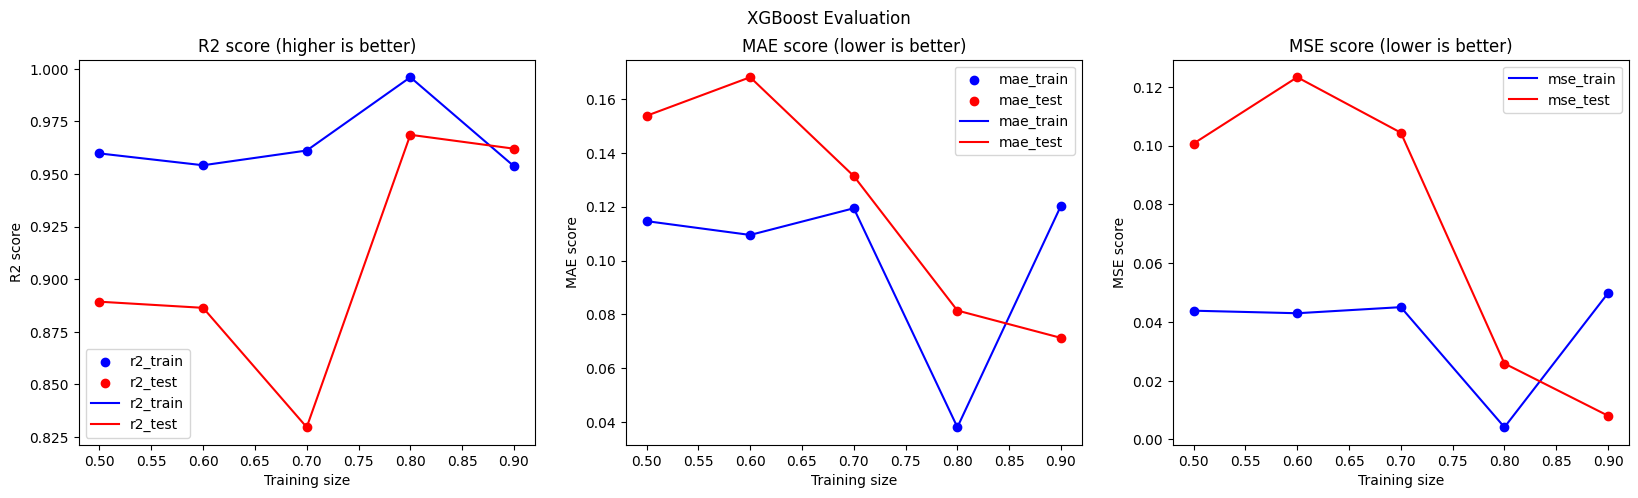

In [9]:
# R2 score
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(train_sizes, lst_r2_train, color = 'blue', label = 'r2_train')
plt.scatter(train_sizes, lst_r2_test, color = 'red', label = 'r2_test')
plt.plot(train_sizes, lst_r2_train, color = 'blue', label = 'r2_train')
plt.plot(train_sizes, lst_r2_test, color = 'red', label = 'r2_test')
plt.legend()
plt.xlabel("Training size")
plt.ylabel("R2 score")
plt.title("R2 score (higher is better)")

# MAE score
plt.subplot(1,3,2)
plt.scatter(train_sizes, lst_mae_train, color = 'blue', label = 'mae_train')
plt.scatter(train_sizes, lst_mae_test, color = 'red', label = 'mae_test')
plt.plot(train_sizes, lst_mae_train, color = 'blue', label = 'mae_train')
plt.plot(train_sizes, lst_mae_test, color = 'red', label = 'mae_test')
plt.legend()
plt.xlabel("Training size")
plt.ylabel("MAE score")
plt.title("MAE score (lower is better)")

# MSE score
plt.subplot(1,3,3)
plt.scatter(train_sizes, lst_mse_train, color = 'blue')
plt.scatter(train_sizes, lst_mse_test, color = 'red')
plt.plot(train_sizes, lst_mse_train, color = 'blue', label = 'mse_train')
plt.plot(train_sizes, lst_mse_test, color = 'red', label = 'mse_test')
plt.legend()
plt.xlabel("Training size")
plt.ylabel("MSE score")
plt.title("MSE score (lower is better)")
plt.suptitle("XGBoost Evaluation")
plt.show()

In [10]:
# Model with best hyper-parameters
xgbr_model = XGBRegressor(objective="reg:squarederror", eval_metric='rmse', n_jobs=-1)
xgbr_model.set_params(**lst_best_params[-2])

xgbr_model.fit(X, Y)
Y_pred = xgbr_model.predict(X)
print(f"R2 score: {r2_score(Y, Y_pred)}")

R2 score: 0.9944918155670166


In [11]:
# Save model weights
with open('../model_checkpoint/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgbr_model, f)